<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Calibrating a Qubit

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import IBMQ
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

### Loading pulse backend
To run OpenPulse experiment, at first we need to load a backend with `open_pulse = True` in the configuration. `DeviceSpecification` class creates a device configuration from backend. You can extract all information from the instanse to create pulse schedule object.

- `device.q` : Returns a list of qubits. Each qubit has `.drive`, `.control`, `.measure` and `.acquire` channels. 
- `device.c` : Returns a list of registers.
- `device.mem` : Returns a list of memory slots.

In this example we use IBMQ Poughkeepsie, a 20 qubit client-only device.

In [ ]:
provider = IBMQ.load_account()
backend_name = 'ibmq_poughkeepsie'
backend = IBMQ.get_backend(backend_name)

In [13]:
device = pulse.DeviceSpecification.create_from(backend)
config = backend.configuration()
defaults = backend.defaults()

/Users/paul/miniconda3/lib/python3.7/site-packages/qiskit_terra-0.9.0-py3.7-macosx-10.7-x86_64.egg/qiskit/pulse/channels/device_specification.py:46: DeprecationWarning: DeviceSpecification is deprecated.Instead of DeviceSpecification, use PulseChannelSpec.
  'Instead of DeviceSpecification, use PulseChannelSpec.', DeprecationWarning)


### Create pulses

Complex pulse enveropes can be defined by using `pulse.function` decorator. A python function which returns an `array_like` object can create any user-defined pulses. The first argument of the function should be `duration` specifing number of data points. The pulses are sent to an arbitrary waveform generator and applied to a quantum bit after mixed with a microwave signal from local oscillators (LO).

In [14]:
# Calculate amplitude from complex signal
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)

## _Running Rabi Experiment_

In this experiment, we apply Rabi drive pulse to qubit0 and measure a signal from the qubit by changing the amplitude of the pulse (`drive_amps`) from 0 to 0.05. Returned signal is integrated and averaged over 512 shot. A `boxcar` kernel is used to process measurement data (**note**: currently the hardware overrides this specification, to be implemented in future versions). The result is stored in `memory_slot[0]`.

In [15]:
#qubit to use for exeperiment
qubit = 0
# exp configuration
exps = 64
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 0.05, exps)
drive_samples = 128
drive_sigma = 16

# Measurement pulse
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_risefall = 25

#scaling factor for data returned by device
scale_factor=1e-10

Pulses are registered to `Schedule`s with information of `channel` and `start_time`. The chanel information is provided by `DeviceSpecification` . `AcquireChannel` is a special type of channels which triggers a digitizer and we cannot add pulses to this type of channels except for `Acquire` commands. Created `Schedule`s can be combined into a single job.

In [16]:
# Measurement pulse (common for all experiment)
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                       sigma=meas_sigma, risefall=meas_risefall, 
                                       name='meas_pulse')
acq_cmd=pulse.Acquire(duration=meas_samples)

# create measurement schedule
measure_and_acquire = meas_pulse(device.q[qubit].measure) | acq_cmd(device.q, device.mem)

# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule += rabi_pulse(device.q[qubit].drive)
    schedule += measure_and_acquire << schedule.duration
 
    schedules.append(schedule)

We may plot any of the experiment schedules with

In [17]:
fig = schedules[-1].draw(channels_to_plot=[device.q[qubit].measure, device.q[qubit].drive],
                         scaling=10.0)

After `Schedule`s are now build for the Rabi experiment. We now assemble the Qobj to be sent to the device. We use `meas_level=1` to get the default kernel integrated results from the device, and we automatically average them with `meas_return='avg'`.

In [18]:
rabi_qobj = assemble(schedules, backend, meas_level=1, meas_return='avg', shots=shots)

After building our rabi experiment QObj we now submit it to the backend to be run.

In [19]:
job = backend.run(rabi_qobj)

We receive a job object for our experiment which we may use to monitor and get the results of the experiment.

In [20]:
job.job_id()

'5d4cc8891494680011fa286b'

In [21]:
job.status()

<JobStatus.RUNNING: 'job is actively running'>

We now ask for the result from the device, which will block until completition (or timeout).

In [22]:
rabi_result = job.result(timeout=3600)

### Analyze the result

The result for our experiment is stored in `memory_slot[qubit]`. The returned data are the integreted values of the received and mixed down stimulus signal applied to the measured resonator averaged over all shots. Looking at the signal amplitude, we will observe an ocillation of the signal as a function of the drive amplitude. This is known as a Rabi oscillation and correspond to the qubit being peridiocally driven to its excited state. This is how we control our qubits.

Below we extract the data from the returned device `memory`. 

In [23]:
qubit_rabi_data = np.ones(exps, dtype=np.complex_)
for i in range(exps):
    qubit_rabi_data[i] = rabi_result.get_memory(i)[qubit]*scale_factor

We now plot and fit the extracted signal to a sinusoid.

Pi Amplitude 0.016155


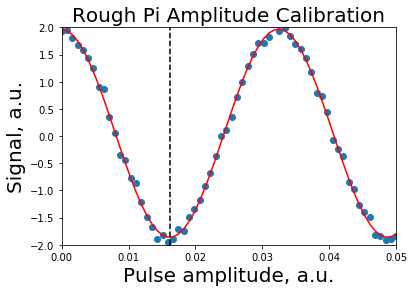

In [28]:
rabi_amp_data = get_amplitude(qubit_rabi_data)

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, drive_amps, rabi_amp_data, [1.0,0.0,0.02,-2])

#get the pi amplitude
pi_amp = (np.pi-fitparams[3])*fitparams[2]/2/np.pi

plt.scatter(drive_amps, rabi_amp_data)
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.xlim(0, 0.05)
plt.ylim(-2, 2)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)

print('Pi Amplitude %f'%(pi_amp))

From the fit we obtain the Rabi oscillation frequency. We may use this to extract the amplitude of a π pulse. This is the required amplitude to drive the qubit from the ground state ($|0>$) to the excited state ($|1>$).

## _Measuring the IQ Distribution from the 0 and 1 States_

In this experiment, we observe a change of measured signals depending on a quantum state of qubit0. By setting `drive_amp` to `pi_amp` we previously obtained, we can apply $\pi$-pulse to the qubit0. To observe a distribution on the IQ plane, we set `meas_return` to `single` .

In [29]:
# Create schedule
rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                amp=pi_amp, 
                                sigma=drive_sigma,
                                name='pi_pulse')
    
# excited
excited_exp = pulse.Schedule(name='pi_exp')
excited_exp += rabi_pulse(device.q[qubit].drive)
measure_time = excited_exp.duration
excited_exp |= measure_and_acquire << measure_time

# ground
ground_exp = pulse.Schedule(name='no_pi_exp')
ground_exp |= pulse.Schedule(name='ground_exp')
ground_exp |= measure_and_acquire << measure_time 

excited_exp_schedules = [ground_exp, excited_exp]

In [30]:
excited_exp_qobj = assemble(excited_exp_schedules, backend, meas_level=1,
                            meas_return='single', shots=shots)

In [31]:
excited_exp_job = backend.run(excited_exp_qobj)

In [ ]:
excited_exp_result = excited_exp_job.result(timeout=3600)

### Analyze the result

In [ ]:
excited_exp_result.get_memory(0)[:, 0].shape

In [ ]:
ground_data = excited_exp_result.get_memory(0)[:, qubit]*scale_factor
excited_data = excited_exp_result.get_memory(1)[:, qubit]*scale_factor


In [ ]:
plt.scatter(np.real(ground_data), np.imag(ground_data), s=5, cmap='viridis',c='blue',alpha=0.5, label='|0>')
plt.scatter(np.real(excited_data), np.imag(excited_data), s=5, cmap='viridis',c='green',alpha=0.5, label='|1>')
ground_center = np.mean(ground_data)
excited_center = np.mean(excited_data)

plt.scatter(np.real(ground_center), np.imag(ground_center), c='blue', s=200, alpha=1.0)
plt.scatter(np.real(excited_center), np.imag(excited_center), c='green', s=200, alpha=1.0)

plt.title('Kernel integrated I-Q scatter plot', fontsize=20)
plt.legend(loc='upper right')
plt.xlabel('I (a.u.)', fontsize=16)
plt.ylabel('Q (a.u.)', fontsize=16)

## _Running Rabi Experiment with Different Frequencies_

Previous experiment is performed without specifying LO frequencies of qubit0. In this case, default drive frequencies from the backend configuration are automatically assigned. These values are calibrated to correspond with the qubit resonanse frequencies. In this experiment, we also change the LO frequencies of qubit0 and see what happens.

In [ ]:
exps_amp = 64
exps_freq = 21
rabi_shots = 512

In [ ]:
drive_lo_freqs = np.linspace(-0.003, 0.003, exps_freq)
freq_qubit_default = defaults.qubit_freq_est[qubit]


In [ ]:
# Create schedule for each frequency
my_jobs = []
for jj, drive_lo_freq in enumerate(drive_lo_freqs):
    freq_d0 = freq_qubit_default + drive_lo_freq
    schedules = []
    schedule_los = []
    for ii, drive_amp in enumerate(drive_amps):
        # drive pulse
        rabi_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                        amp=drive_amp, sigma=drive_sigma,
                                        name='drive_pulse_%d' % ii)
        
        # add commands to schedule
        schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)

        schedule += rabi_pulse(device.q[qubit].drive)
        schedule += measure_and_acquire << schedule.duration

        schedules.append(schedule)
        
        # set LO frequency
        schedule_los.append(pulse.LoConfig({device.q[0].drive: freq_d0}))
    
    # Run on the real backend
    qobj = assemble(schedules, backend, meas_level=1, meas_return='avg', shots=shots,
                    schedule_los=schedule_los)
    job = backend.run(qobj)
    
    my_jobs.append(job)

In [ ]:
for ii, job in enumerate(my_jobs):
    print('%s: %s' % (ii, job.status()))

### Analyze the result

As in the same manner as the previous experiment, we calculate signal amplitude for each experiment. The result provides a 2 dimensional array of signal amplitude with respect to drive amplitude and frequency. This is called qubit chevron pattern and we can see the change of Rabi rate that comes with the detuning of drive frequency.

## Warning: this sends a lot of jobs

In [ ]:
chevron_data = np.zeros((exps_amp, exps_freq), dtype=np.float64)

for i, job in enumerate(my_jobs):
    print(job.job_id())
    result = job.result()

    for j in range(exps_amp):
        chevron_data[j, i] = np.abs(result.get_memory(j)[qubit]*scale_factor)
        

In [ ]:
plt.imshow(chevron_data,
           extent=[drive_lo_freqs.min() * 1e3, drive_lo_freqs.max() * 1e3, drive_amps.min(), drive_amps.max()],
           cmap='jet',
           origin='lowest', aspect='auto')
plt.colorbar()
plt.xlabel('Frequency detuning, MHz', fontsize=20)
plt.ylabel('Pulse amplitude, a.u.', fontsize=20)